In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
wt= pd.read_csv("weather2024.csv")

In [7]:
wt

,일시,기온,강수량,풍속,습도,일사
0,2024-01-01 01:00,3.8,0.0,1.5,80,0.0
1,2024-01-01 02:00,3.9,0.0,0.2,79,0.0
2,2024-01-01 03:00,3.5,0.0,0.4,84,0.0
3,2024-01-01 04:00,1.9,0.0,1.1,92,0.0
4,2024-01-01 05:00,1.4,0.0,1.5,94,0.0
...,...,...,...,...,...,...
8755,2024-12-30 20:00,7.6,0.0,1.4,71,0.0
8756,2024-12-30 21:00,7.5,0.0,1.7,69,0.0
8757,2024-12-30 22:00,7.2,0.0,1.2,70,0.0
8758,2024-12-30 23:00,7.2,0.0,1.7,71,0.0


In [8]:
wt.columns = ['date', 'tem', 'rain', 'wind', 'hum', 'sol']

* 전체 기간 시도표

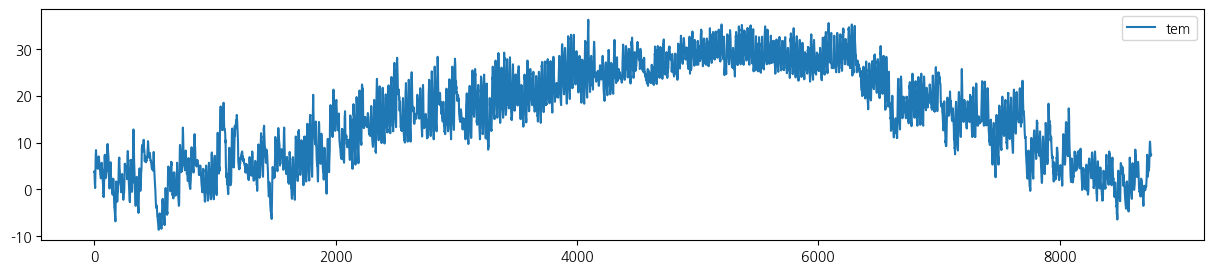

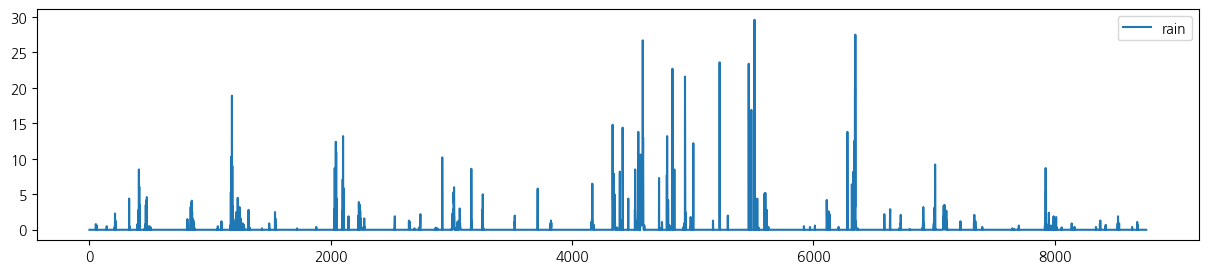

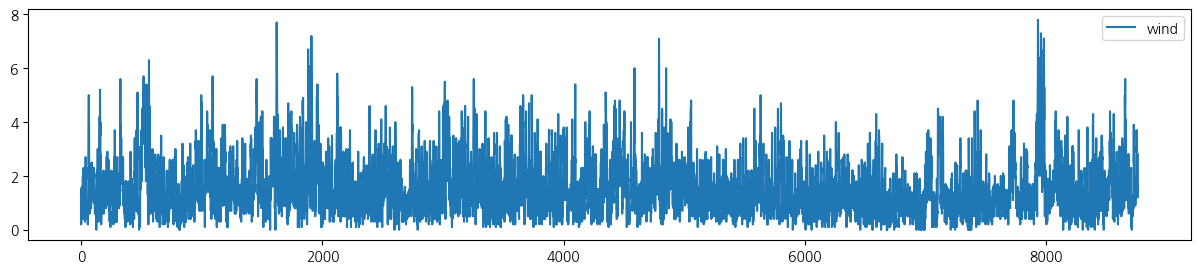

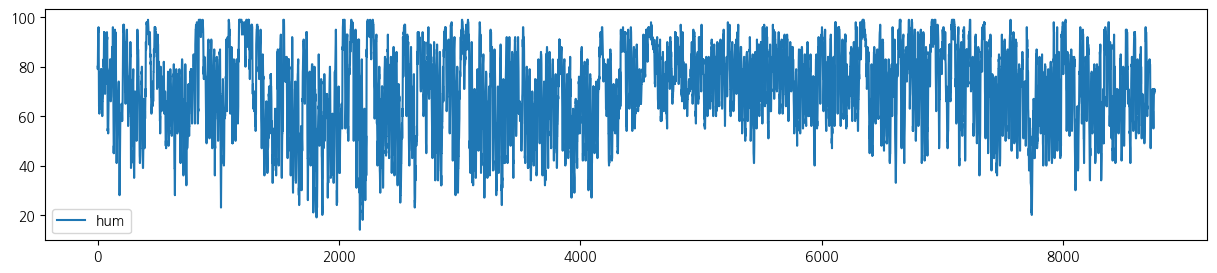

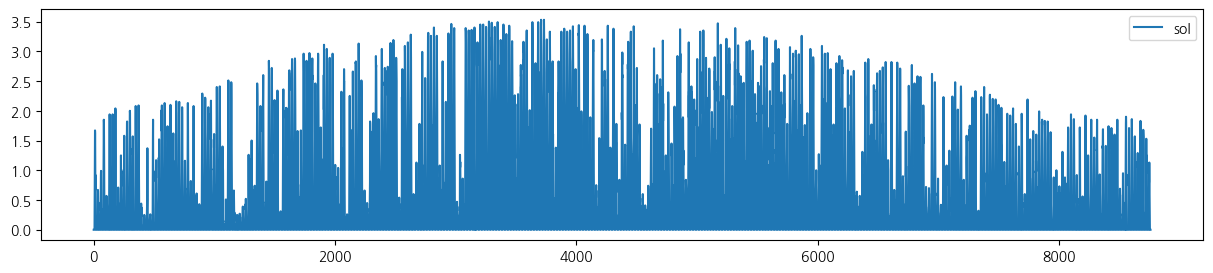

In [10]:
for i in range(5):
    wt.iloc[:,[i+1]].plot(figsize=(15, 3));

* 첫 1주일 시도표

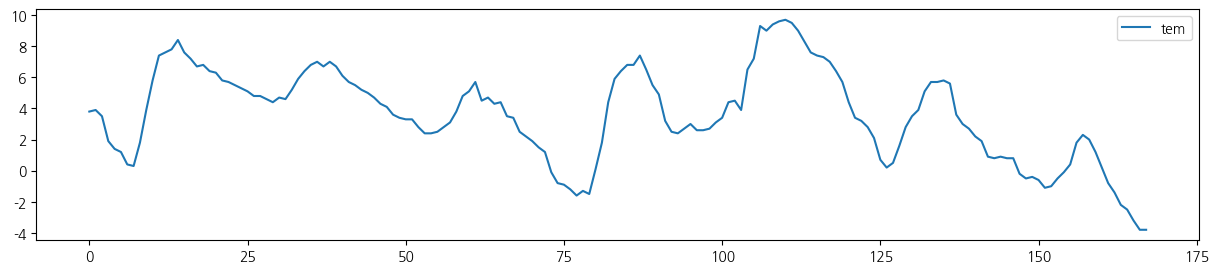

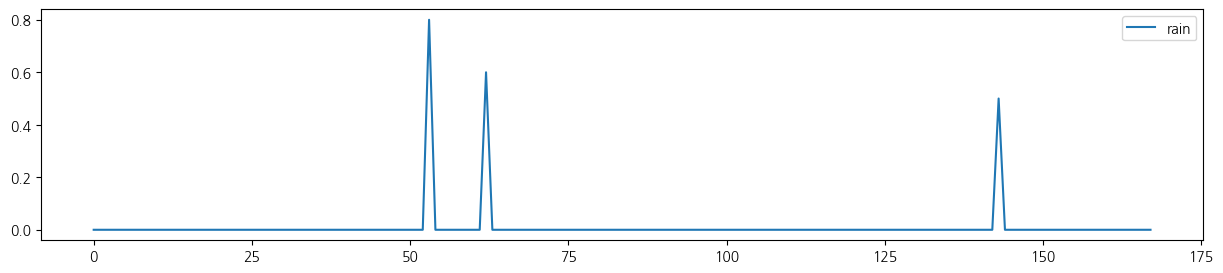

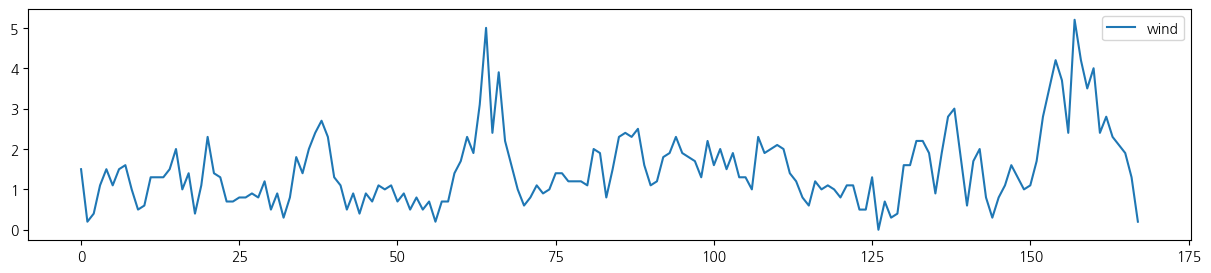

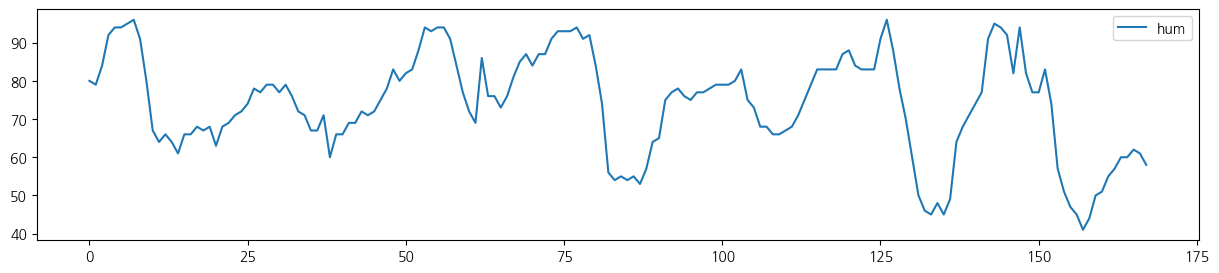

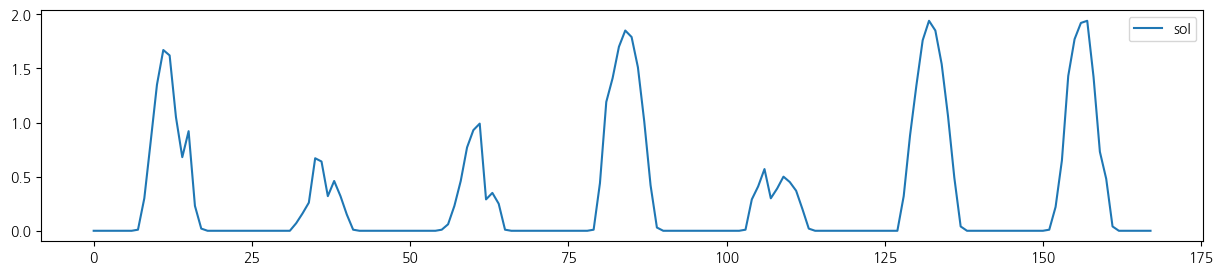

In [13]:
for i in range(5):
    wt.iloc[:24*7,[i+1]].plot(figsize=(15, 3));

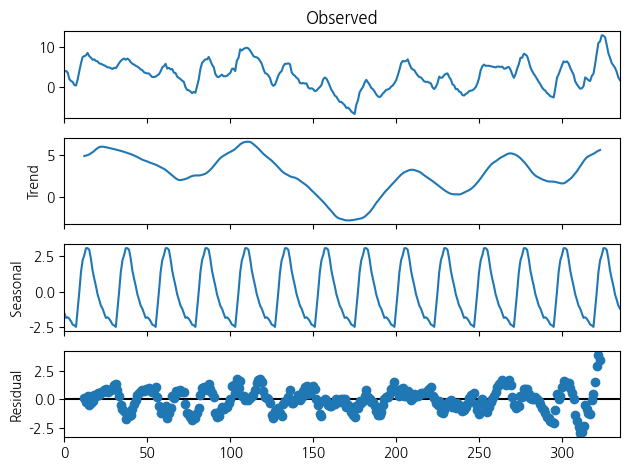

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

#ts = pd.Series(dff.iloc[:24*7,[0+1]].values, index=pd.date_range(start='2024-01-01', periods=24, freq='H'))

# 분해 수행 (Additive 모델, 주기성 주기=24시간)
result = seasonal_decompose(wt.iloc[:24*14,[0+1]].values, model='additive', period=24)

# 시각화
result.plot()
#plt.suptitle("시계열 분해 결과 (추세 + 계절 + 잡음)")
plt.tight_layout()
plt.show()

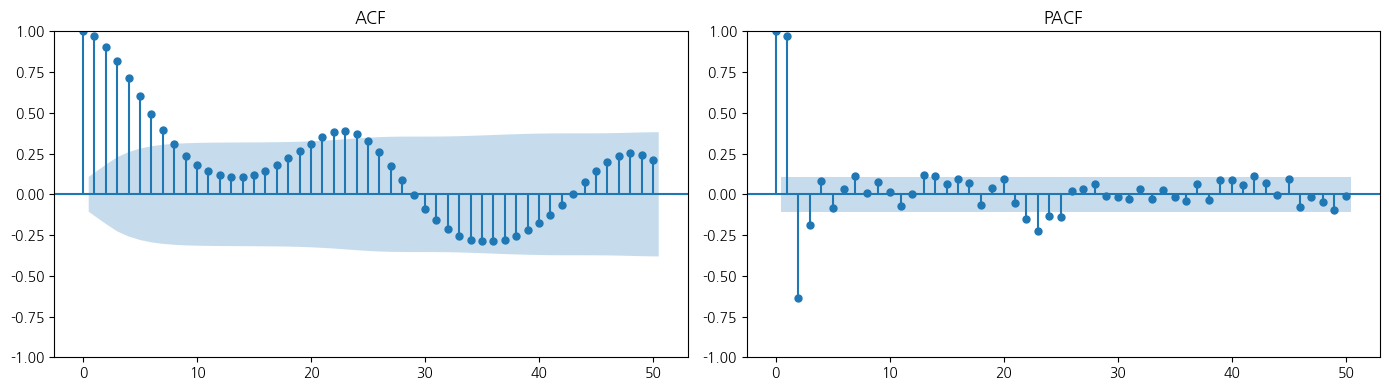

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts=wt.iloc[:24*14,[0+1]].values
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts, lags=50, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(ts, lags=50, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [19]:
wt.iloc[:,1:].corr()

,tem,rain,wind,hum,sol
tem,1.000000,0.051619,0.016475,-0.056472,0.348940
rain,0.051619,1.000000,0.045720,0.184801,-0.070628
wind,0.016475,0.045720,1.000000,-0.311978,0.284515
hum,-0.056472,0.184801,-0.311978,1.000000,-0.620501
sol,0.348940,-0.070628,0.284515,-0.620501,1.000000


### VAR 모형에 적합

* $X$ : y의 과거값 및 외생변수, 길이는 24*14
* $y$ : 예측하고자 하는 일사량, 길이는 24

1. 온도와 일사량

In [43]:
X = wt.iloc[:24*14,[1,-1]]
y = wt.iloc[24*14:24*15,1:]

In [44]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
# 데이터: y, x1~x4가 있는 시계열 데이터프레임
# 인덱스는 datetime이어야 함

# 1. 정상성 검사 및 필요시 차분 (여기선 생략, 필요시 추가해줘)

# 2. VAR 모형 적합
model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=48)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
#print(results.summary())

AIC 기준 최적 시차: 21


In [45]:
n_forecast = 21
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast1 = results.forecast(y=forecast_input, steps=n_forecast)

2. 습도와 일사량

In [46]:
X = wt.iloc[:24*14,[-2,-1]]
#y = wt.iloc[24*7:24*8,1:]

model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=24)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
results.summary()

AIC 기준 최적 시차: 21


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Mar, 2025
Time:                     08:39:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0867873
Nobs:                     315.000    HQIC:                 -0.528393
Log likelihood:          -660.240    FPE:                   0.392863
AIC:                    -0.937725    Det(Omega_mle):        0.304156
--------------------------------------------------------------------
Results for equation hum
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          12.877262         3.048607            4.224           0.000
L1.hum          1.034009         0.064842           15.947           0.000
L1.sol         -6.288329         1.841606           -3.415           0.001
L2.hum     

In [47]:
n_forecast = 21
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast2 = results.forecast(y=forecast_input, steps=n_forecast)

3. 풍속과 일사량

In [48]:
X = wt.iloc[:24*14,[-3,-1]]
#y = wt.iloc[24*7:24*8,1:]

model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=24)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
results.summary()

n_forecast = 21
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast2_ = results.forecast(y=forecast_input, steps=n_forecast)

AIC 기준 최적 시차: 21


4. 강수량과 일사량

In [49]:
X = wt.iloc[:24*14,[-4,-1]]
#y = wt.iloc[24*7:24*8,1:]

model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=24)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
results.summary()

n_forecast = 21
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast3_ = results.forecast(y=forecast_input, steps=n_forecast)

AIC 기준 최적 시차: 20


* AR 모형 일사량만 이용

In [50]:
from statsmodels.tsa.ar_model import AutoReg

# 예시: y 시계열 데이터프레임 (datetime index 권장)
# df = pd.read_csv("your_data.csv", index_col=0, parse_dates=True)
# y = df['y']
y_ = wt.iloc[:24*14,[-1]]# 시계열 형태로 가져오기

# 1. 시차(p) 설정 또는 자동 선택
p = 21  # 최근 24시간을 기반으로 다음을 예측한다고 가정

# 2. AR 모형 적합
model = AutoReg(y_, lags=p, old_names=False)
results = model.fit()

# 3. 다음 24시간 예측
forecast3 = results.predict(start=len(y), end=len(y)+23)

In [51]:
print('온도, 일사량',mean_squared_error(y['sol'].values,forecast1[:,1]))
print('습도, 일사량',mean_squared_error(y['sol'].values,forecast2[:,1]))
print('풍속, 일사량',mean_squared_error(y['sol'].values,forecast2_[:,1]))
print('강수량, 일사량',mean_squared_error(y['sol'].values,forecast3_[:,1]))

print('일사량',mean_squared_error(y['sol'].values,forecast3))



plt.figure(figsize = (15,7))
plt.plot(y['sol'].values, label = 'y',color = 'black')
plt.plot(forecast1[:,1],label = 'tem+sol')
plt.plot(forecast2[:,1],label = 'hum+sol')
plt.plot(forecast2_[:,1],label = 'wind+sol')
plt.plot(forecast3_[:,1],label = 'rain+sol')

plt.plot(forecast3.values,label = 'sol')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [24, 21]